In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams
import matplotlib.ticker as ticker
import numpy as np
import datetime

import os
path = os.getcwd()

In [110]:
# imports
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import make_column_selector
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import make_union
from sklearn.compose import make_column_transformer
from sklearn import set_config
from sklearn.linear_model import Ridge
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import seaborn as sns

In [111]:
df= pd.read_csv('UPDATE_full_data_clean_inclCluster.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,Store ID,Item ID,Store Category,Store Segment,Store Region,City,Store Address,Item First Supplying Date,...,Count Ratings,Declared Supply,Meals Saved,Total Supply,Avg Rating Overall,Pickup Length,Supply Length,Region Language,Region Type,Cluster
0,0,0,11344,11438,Key Account,Bakery,Genève,GenÃ¨ve,Place de Cornavin 7,2017-12-07 00:00:00,...,0,20,2,20,0.00,0 days 00:50:00,1545,french,urban,0
1,1,1,11729,11822,Indie - Outbound,Buffet,Bern,Bern,LÃ¤nggassstrasse 53,2018-11-02 00:00:00,...,1,0,9,16,4.00,0 days 04:00:00,237,german,urban,0
2,2,2,11729,11822,Indie - Outbound,Buffet,Bern,Bern,LÃ¤nggassstrasse 53,2018-11-02 00:00:00,...,8,0,28,33,4.25,0 days 04:00:00,237,german,urban,0
3,3,3,11729,11822,Indie - Outbound,Buffet,Bern,Bern,LÃ¤nggassstrasse 53,2018-11-02 00:00:00,...,0,10,11,17,0.00,0 days 04:00:00,237,german,urban,0
4,4,4,11729,11822,Indie - Outbound,Buffet,Bern,Bern,LÃ¤nggassstrasse 53,2018-11-02 00:00:00,...,1,10,13,17,5.00,0 days 04:00:00,237,german,urban,0


In [112]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2616743 entries, 0 to 2616742
Data columns (total 25 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   Unnamed: 0                     int64  
 1   Unnamed: 0.1                   int64  
 2   Store ID                       int64  
 3   Item ID                        int64  
 4   Store Category                 object 
 5   Store Segment                  object 
 6   Store Region                   object 
 7   City                           object 
 8   Store Address                  object 
 9   Item First Supplying Date      object 
 10  Item Last Supplying Date       object 
 11  Item Price                     float64
 12  Pickup Time Start Time of Day  object 
 13  Pickup Time End Time of Day    object 
 14  Date                           object 
 15  Count Ratings                  int64  
 16  Declared Supply                int64  
 17  Meals Saved                    int64  
 18  To

## Data Preprocessing

In [113]:
# Check for duplicates
df.duplicated().sum()

0

In [114]:
# Check for nan:
df.isnull().sum().sort_values(ascending=False)

Unnamed: 0                       0
Pickup Time End Time of Day      0
Region Type                      0
Region Language                  0
Supply Length                    0
Pickup Length                    0
Avg Rating Overall               0
Total Supply                     0
Meals Saved                      0
Declared Supply                  0
Count Ratings                    0
Date                             0
Pickup Time Start Time of Day    0
Unnamed: 0.1                     0
Item Price                       0
Item Last Supplying Date         0
Item First Supplying Date        0
Store Address                    0
City                             0
Store Region                     0
Store Segment                    0
Store Category                   0
Item ID                          0
Store ID                         0
Cluster                          0
dtype: int64

In [115]:
# Check for date columns to remove:
df[['Date','Item First Supplying Date','Item Last Supplying Date','Pickup Time Start Time of Day','Pickup Time End Time of Day']].head()

,Date,Item First Supplying Date,Item Last Supplying Date,Pickup Time Start Time of Day,Pickup Time End Time of Day
0,2019-01-01 00:00:00,2017-12-07 00:00:00,2022-03-01 00:00:00,1900-01-01 20:00:00,1900-01-01 20:50:00
1,2019-01-01 00:00:00,2018-11-02 00:00:00,2019-06-27 00:00:00,1900-01-01 18:30:00,1900-01-01 22:30:00
2,2019-01-02 00:00:00,2018-11-02 00:00:00,2019-06-27 00:00:00,1900-01-01 18:30:00,1900-01-01 22:30:00
3,2019-01-27 00:00:00,2018-11-02 00:00:00,2019-06-27 00:00:00,1900-01-01 18:30:00,1900-01-01 22:30:00
4,2019-01-31 00:00:00,2018-11-02 00:00:00,2019-06-27 00:00:00,1900-01-01 18:30:00,1900-01-01 22:30:00


### Add column to cluster Pickup start time

In [116]:
# Add column to cluster Pickup start time:
conditions = [
    (df['Pickup Time Start Time of Day'] <= "1900-01-01 11:59:00"),
    (df['Pickup Time Start Time of Day'] >= "1900-01-01 12:00:00") & (df['Pickup Time Start Time of Day'] < "1900-01-01 17:00:00"),
    (df['Pickup Time Start Time of Day'] >= "1900-01-01 17:00:00") & (df['Pickup Time Start Time of Day'] < "1900-01-01 21:00:00"),
    (df['Pickup Time Start Time of Day'] >= "1900-01-01 21:00:00")
    ]

values = ['morning', 'afternoon', 'early evening', 'late evening']

df['Pickup_time_of_day'] = np.select(conditions, values)

###  Convert Pickup Length

In [117]:
# Fuction to convert:
def pickup_conv(x):
    x=str(x)
    x=x[len(x)-8:len(x)]
    h,m,s = x.split(':')
    x=int((datetime.timedelta(hours=int(h),minutes=int(m),seconds=int(s)).total_seconds())/60)
    return x

In [118]:
#Converting the whole column
df['Pickup Length']=df['Pickup Length'].map(pickup_conv)

In [143]:
encoding = {"morning": 0, "afternoon": 1, "early evening": 2, "late evening": 3}
df["encoded pickup time"] = df["Pickup_time_of_day"].map(encoding)

In [144]:
df.head(3)

,Unnamed: 0,Unnamed: 0.1,Store ID,Item ID,Store Category,Store Segment,Store Region,City,Store Address,Item First Supplying Date,...,Meals Saved,Total Supply,Avg Rating Overall,Pickup Length,Supply Length,Region Language,Region Type,Cluster,Pickup_time_of_day,encoded pickup time
0,0,0,11344,11438,Key Account,Bakery,Genève,GenÃ¨ve,Place de Cornavin 7,2017-12-07 00:00:00,...,2,20,0.00,50,1545,french,urban,0,early evening,2
1,1,1,11729,11822,Indie - Outbound,Buffet,Bern,Bern,LÃ¤nggassstrasse 53,2018-11-02 00:00:00,...,9,16,4.00,240,237,german,urban,0,early evening,2
2,2,2,11729,11822,Indie - Outbound,Buffet,Bern,Bern,LÃ¤nggassstrasse 53,2018-11-02 00:00:00,...,28,33,4.25,240,237,german,urban,0,early evening,2


### Define Features

<AxesSubplot:>

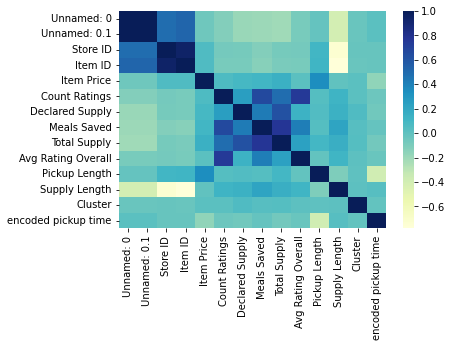

In [145]:
# Heatmap
corr = df.corr()
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns,
        cmap= "YlGnBu")

In [146]:
corr_df = corr.unstack().reset_index() # Unstack correlation matrix 
corr_df.columns = ['feature_1','feature_2', 'correlation'] # rename columns
corr_df.sort_values(by="correlation",ascending=False, inplace=True) # sort by correlation
corr_df = corr_df[corr_df['feature_1'] != corr_df['feature_2']] # Remove self correlation
corr_df.head()

,feature_1,feature_2,correlation
14,Unnamed: 0.1,Unnamed: 0,0.999999
1,Unnamed: 0,Unnamed: 0.1,0.999999
31,Store ID,Item ID,0.942659
44,Item ID,Store ID,0.942659
106,Meals Saved,Total Supply,0.767613


### Define X and y

In [172]:
# Remove columns: define X and y
X = df.drop(columns=['Pickup_time_of_day','Unnamed: 0','Unnamed: 0.1','Store ID','Item ID','Date','Item First Supplying Date','Item Last Supplying Date','Pickup Time Start Time of Day','Pickup Time End Time of Day','City','Store Address', "Total Supply", "Declared Supply", "Count Ratings", "Supply Length", "encoded pickup time", "Avg Rating Overall", "Meals Saved"])
y = df["encoded pickup time"]


In [173]:
X.head()

,Store Category,Store Segment,Store Region,Item Price,Pickup Length,Region Language,Region Type,Cluster
0,Key Account,Bakery,Genève,4.5,50,french,urban,0
1,Indie - Outbound,Buffet,Bern,6.9,240,german,urban,0
2,Indie - Outbound,Buffet,Bern,6.9,240,german,urban,0
3,Indie - Outbound,Buffet,Bern,6.9,240,german,urban,0
4,Indie - Outbound,Buffet,Bern,6.9,240,german,urban,0


In [153]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2616743 entries, 0 to 2616742
Data columns (total 10 columns):
 #   Column              Dtype  
---  ------              -----  
 0   Store Category      object 
 1   Store Segment       object 
 2   Store Region        object 
 3   Item Price          float64
 4   Meals Saved         int64  
 5   Avg Rating Overall  float64
 6   Pickup Length       int64  
 7   Region Language     object 
 8   Region Type         object 
 9   Cluster             int64  
dtypes: float64(2), int64(3), object(5)
memory usage: 199.6+ MB


In [154]:
X.describe()

,Item Price,Meals Saved,Avg Rating Overall,Pickup Length,Cluster
count,2.616743e+06,2.616743e+06,2.616743e+06,2.616743e+06,2.616743e+06
mean,6.572431e+00,1.752282e+00,2.003468e+00,4.856899e+01,1.599506e+00
std,2.704585e+00,2.099286e+00,2.300168e+00,7.977479e+01,1.155228e+00
min,1.000000e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,4.900000e+00,0.000000e+00,0.000000e+00,3.000000e+01,1.000000e+00
50%,5.900000e+00,1.000000e+00,0.000000e+00,3.000000e+01,2.000000e+00
75%,6.900000e+00,2.000000e+00,5.000000e+00,3.000000e+01,3.000000e+00
max,9.490000e+01,8.000000e+02,5.000000e+00,1.410000e+03,3.000000e+00


<AxesSubplot:xlabel='encoded pickup time', ylabel='Count'>

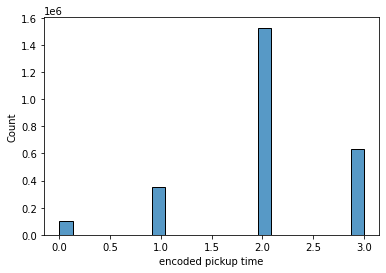

In [170]:
sns.histplot(data=df, x="encoded pickup time")

# Model 1: y=Price

In [155]:
# Split into Train/Test -> to do on all dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state =42)

In [156]:
num_transformer = make_pipeline(RobustScaler())    #### Removed Simple Imputer
cat_transformer = make_pipeline(OneHotEncoder(handle_unknown='ignore'))
preprocess = make_column_transformer((num_transformer, ['Meals Saved', 'Avg Rating Overall','Item Price', "Cluster"]),
                                     (cat_transformer,['Store Category', 'Store Segment', 'Store Region', 'Region Language', 'Region Type']))


In [157]:
# visualizing pipelines in HTML
#set_config(display='diagram')
#preprocess

In [158]:
#preprocess.fit(X_train)
X_train_transformed = preprocess.fit_transform(X_train)

In [159]:
display(pd.DataFrame(X_train_transformed.todense()).head(3))

,0,1,2,3,4,5,6,7,8,9,...,52,53,54,55,56,57,58,59,60,61
0,0.0,0.0,-0.5,-0.5,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,0.0,0.0,0.5,0.5,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
2,0.0,0.0,0.5,0.5,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


In [160]:
# Add Estimator
#pipe = make_pipeline(preprocess, Ridge())
pipe = make_pipeline(preprocess, LogisticRegression(multi_class='multinomial',solver ='newton-cg'))
pipe

Pipeline(memory=None,
         steps=[('columntransformer',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('pipeline-1',
                                                  Pipeline(memory=None,
                                                           steps=[('robustscaler',
                                                                   RobustScaler(copy=True,
                                                                                quantile_range=(25.0,
                                                                                                75.0),
                                                                                with_centering=True,
                                                                                with_scaling=True))],
                                      

In [164]:
# Train pipeline
pipe.fit(X_train[:100000], y_train[:100000])

# Make predictions
pipe.predict(X_test[100000:120000])

# Score model
pipe.score(X_test[100000:120000], y_test[100000:120000])

0.67035

In [171]:
# Cross validate pipeline
cross_val_score(pipe, X_train, y_train, cv=3, scoring='r2').mean()

/Users/ninadamaso/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/ninadamaso/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/sklearn/utils/optimize.py:204: UserWarning: Line Search failed
  warnings.warn('Line Search failed')
/Users/ninadamaso/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/ninadamaso/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/sklearn/utils/optimize.py:204: UserWarning: Line Search failed
  warnings.warn('Line Search failed')


0.05286155189649481

In [ ]:
# Checking correlation between independent variables (features):
# Need to encode categorical variables
plt.figure(figsize=(28,10))
sns.heatmap(X_train.corr(), cmap='coolwarm', annot = True, annot_kws={"size": 8})